# Creating a circuit that entangled qubits


### Taking 3 qubits and 3 classical bit and then measuring the outcome

In [2]:
from qiskit import * # From qiskit import everything

nqubits = 3 # Taking 3 qubits
nclassical = 3 # Taking 3 classical bits
circuits = QuantumCircuit(nqubits,nclassical) # define a QuantumCircuit with 3 Qubit and 3 Classical bit
circuits.h(0)  # Using ane hadamard gate to create a superposition state
circuits.cx(0,1) # Using two CNOT gate so that we can create a Bell state or entangled state
circuits.cx(1,2) 
circuits.measure([0,1,2],[0,1,2]) # Measuring the circuit

# Drawing the circuit  

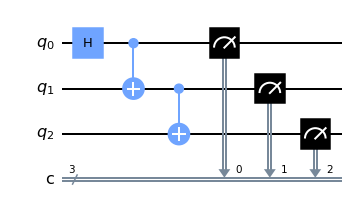

In [3]:
# Here we can see the circuit representation of our code above
%matplotlib inline
circuits.draw(output='mpl') 

# Running on local simulator

In [4]:
simulator = Aer.get_backend('qasm_simulator') # Taking qasm_simulator as local simulator
sim_result = execute(circuits, backend=simulator, shots =1024).result() # Executing the circuit and getting the result

# plotting on histogram

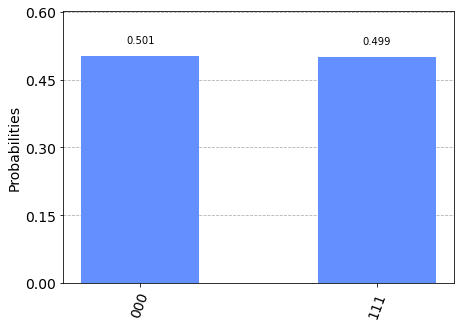

In [9]:
from qiskit.visualization import plot_histogram 
plot_histogram(sim_result.get_counts(circuits))

# Now let's try to run it on real quantum computer

In [10]:
from qiskit import IBMQ

In [12]:
IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

# Now we will be able to do some computation on real Quantum Computer


In [13]:
from qiskit.providers.ibmq import IBMQ, least_busy
provider = IBMQ.get_provider('ibm-q')
device = least_busy(provider.backends(filters=lambda x: not x.configuration().simulator))
print(f'Running on {device.name()}')

Running on ibmq_quito


In [15]:
# Forming the program so that the device can run it
# It is known as transpiling
from qiskit import transpile
transpiled_qc = transpile(circuits, device)

In [16]:
# Sending the program off to the IBM Quantum to run on a real device
# and monitoring its status

from qiskit.tools import job_monitor
job = device.run(transpiled_qc)
job_monitor(job)

Job Status: job has successfully run


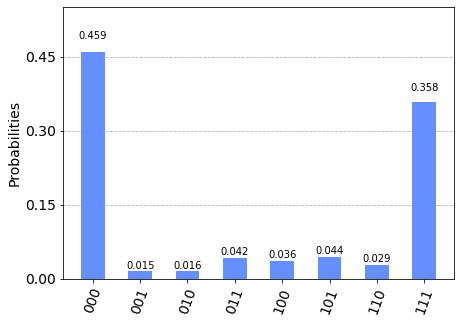

In [17]:
# Plotting the result as histogram
from qiskit.visualization import plot_histogram
plot_histogram(job.result().get_counts())

# Let's investigate the entanglement 

In [21]:
from qiskit.quantum_info import Statevector

nqubits = 3
nclassical = 3
circuits = QuantumCircuit(nqubits,nclassical)
circuits.h(0)
circuits.cx(0,1)
circuits.cx(1,2)

ket = Statevector(circuits)
ket.draw(output='latex')

<IPython.core.display.Latex object>

# Now try to mitigate the noise that we got from real Quantum Computer

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit 
from qiskit.visualization import plot_histogram
from qiskit_experiments.library import LocalReadoutError, CorrelatedReadoutError

from qiskit.visualization import plot_histogram
from qiskit.providers.aer import AerSimulator
from qiskit.providers.fake_provider import FakeParis

from qiskit.result.mitigation.utils import (
     expval_with_stddev,
     str2diag,
     counts_probability_vector
)

backend = AerSimulator.from_backend(FakeParis())

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
/opt/conda/lib/python3.8/site-packages/qiskit/providers/aer/noise/device/models.py:264: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value 2 * T_1 (78724.73839768364 > 2 * 17977.586136949183). Truncating to maximum value.
  warn("Device model returned an invalid T_2 relaxation time greater than"
/opt/conda/lib/python3.8/site-packages/qiskit/providers/aer/noise/device/models.py:264: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value 2 * T_1 (151392.40575779957 > 2 * 69749.41874968237). Truncating to maximum value.
  warn("Device model returned an invalid T_2 relaxation time greater than"
/opt/conda/lib/python3.8/site-packages/qiskit/providers/aer/noise/device/models.py:264: UserWarning: 

In [13]:
nqubits = 3
nclassical = 3
circuits = QuantumCircuit(nqubits,nclassical)
circuits.h(0)
circuits.cx(0,1)
circuits.cx(1,2)
circuits.measure([0,1,2],[0,1,2])

In [14]:
SHOTS = 1024
qubits = [0,1,2]
num_qubits = len(qubits)

In [15]:
exp = LocalReadoutError(qubits)

In [16]:
exp.analysis.set_options(plot=True)
result = exp.run(backend)
mitigator = result.analysis_results(0).value

In [17]:
counts = backend.run(circuits, shots=SHOTS, seed_simulator=42, method="density_matrix").result().get_counts()
unmitigated_probs = {label: count / SHOTS for label, count in counts.items()}

In [18]:
mitigated_quasi_probs = mitigator.quasi_probabilities(counts)
mitigated_stddev = mitigated_quasi_probs._stddev_upper_bound
mitigated_probs = (mitigated_quasi_probs.nearest_probability_distribution().binary_probabilities())

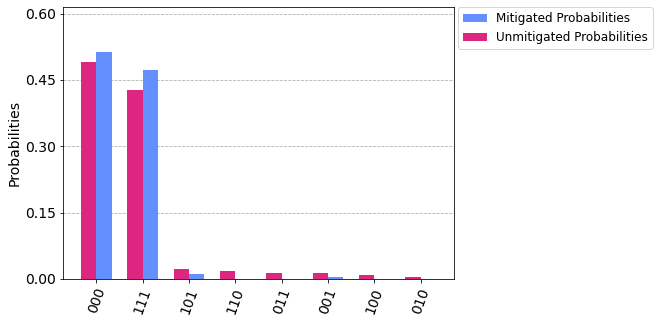

In [19]:
legend = ['Mitigated Probabilities', 'Unmitigated Probabilities']
plot_histogram([mitigated_probs, unmitigated_probs], legend=legend, sort="value_desc", bar_labels=False)